# Refactoring and Packaging Research Python Code
## With an example from agent-based financial modeling

This notebook is inspired by a [previous guide of mine](https://github.com/embray/notebooks/blob/master/simcluster.ipynb) of a similar nature, though designed originally for an astronomy audience (though the code is simple enough that most people with some background in scientific Python ([SciPy](https://www.scipy.org/scipylib/index.html), [NumPy](http://numpy.org/) should be able to follow it.  It was also based on Python 2.7, so a few of the details, especially concerning packaging, are a little bit outdated.  But the main points are still relevant, so it may make for an interesting companion to this guide.

### Introduction
The example code used from this tutorial is based on a simple implementation of an, simple two-type model by Gaunersdorfer and Hommes, taken from [this online book](http://people.brandeis.edu/~blebaron/classes/agentfin/GaunersdorferHommes.html) by LeBaron.  It should be noted that the author of *this notebook* has no background in finance or agent-based modeling.  Although I have taken time to understand the basic concepts and algorithm underlying this model, for all intents and purposes it might as well be an otherwise opaque blob of code.  This is to say, the techniques presented here are not particular to any specific code for any specific purpose--I found this code to be a good example of what I would call "typical research code" that one might encounter, and was chosen from this domain to suit the particular audience.

Another preliminary qualification: When I say "typical research code" I do not mean it at all pejoratively.  In fact, I would say there is virtually nothing wrong with this code (at least stylistically--I cannot say for sure that there are no bugs!).  What I mean, rather, is code that is generally written at the "top level" of the source (or "module level" in Python parlance), often in a single file, with many global variables and few if any subroutines, more closely resembling pseudo-code, or an interactive coding session to implement some algorithm.  Code like this, at least when it is *relatively short* (no more than a few hundred lines) can be easy to share, and easy for other researchers to understand (the closer it looks to pseudo-code the better, which is partly why Python is nice for this), and is also well-suited to pedagogical contexts and interactive notebook environments.

However, there certain features that this style of code *lacks* which may become a problem, especially as the size and complexity of the code grows (as it often does over time) and *especially* once we want to make the code widely available and easier to install into part of a larger ecosystem through the process of *packaging*.  To throw out a few words representing the problems we'd like to tackle, in no particular order:

* Modularity
* Reusability
* Interoperability
* Reproducibility
* Distributability (?)
* ...among other "-ity"s

This short guide will try to address a few of these, and possibly others.  Time-permitting we can go over more topics in-person as well.

It's worth noting that there are many other resources as it relates to these subjects, both in software engineering in general, or specifically for Python.  Just plug terms like "python modularity" into your favorite search engine and you'll get tons of hits.  I thought [this one](https://realpython.com/python-modules-packages/) was pretty good, for example.

### The original code

In [1]:
# First a minor preliminary needed sometimes to display inline plots in the notebook:
%matplotlib inline

# Let's also double-check where we are on the filesystem
import os
os.getcwd()

'C:\\Users\\Erik M. Bray\\Home\\src\\agentfin'

C:\Users\Erik M. Bray\Home\miniconda3\envs\agentfin\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


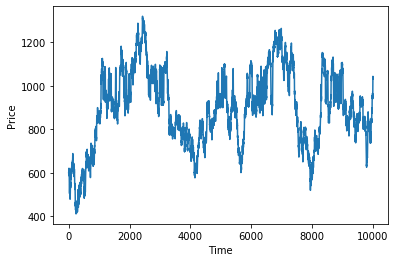

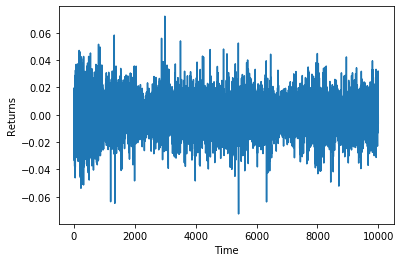

In [2]:
# %load gaunersdorfer_hommes/gaunersdorfer_hommes.py

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)

T = 10000     #Time Horizon
# For GHW model with low D chaos set chaos = 1
# For GH  model with limit cycle and realistic price dynamics set chaos = 0

# The model is written with the dynamics in terms of deviations
# from the constant fundamental given by pbar
# as x(t) = p(t)-pbar
# this is both a little simpler, and turns out to be a better
# thing to do numerically.  See notes for some details

chaos = 0

# a*sigma(risk aversion * variance)
asig = 1
ybar = 1

if chaos == 1:
    T = 500
    r = 0.01
    pstar = ybar/r
    beta = 4
    v = 0.3
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4 # chaos
    eta = 0
    # std for price noise
    epssig = 0
    alpha = 10
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    riskAdjust = 1
    # starting price level
    startx = 0.01
else:
    r = 0.001
    pstar = ybar/r
    beta = 2
    v = 1
    g = 1.9
    alpha = 1800
    eta = 0.99
    riskAdjust = 0
    epssig = 10
    startx = -400

n2 = np.zeros([T, 1])       # Fraction of type 2
p = np.zeros([T, 1])        # Price
R = np.zeros([T,1])         # Per share Return
# x = deviation from fundamental (pstar)
x = np.zeros([T,1])         # p - pstar (used in most dynamics)
u1 = np.zeros([T,1])        # type 1 accumulated realized profits
u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
z1 = 0.5 * np.ones([T,1])   # share holdings type 1
z2 = 0.5 * np.ones([T,1])   # share holdings type 2
eps = epssig * np.random.randn(T) # additive pricing noise
nn = np.zeros([T,1])

# initial value

# fraction of agents
n2[0] = 0.5
n2[1] = n2[0]
n2[2] = n2[1]
n2[3] = n2[2]

# x = price - pstar
x[0] = startx
x[1] = x[0]
x[2] = x[1]
x[3] = x[2]

p = pstar + x

# start at t = 5 to allow for lags
for t in range(4,T):
    # update utility
    # simplified equation from paper(see GHW equation(12))
    # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
    # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
    # detaled one period profits using last period holdings
    pi1 = R[t-1]* z1[t-2] - riskAdjust * 0.5 * asig * z1[t-2]**2
    pi2 = R[t-1]* z2[t-2] - riskAdjust * 0.5 * asig * z2[t-2]**2
    # accumulated fitness
    u1[t-1] = pi1 + eta * u1[t-2]
    u2[t-1] = pi2 + eta * u2[t-2]
    # normalization for logistice
    norm = np.exp( beta * u1[t-1]) + np.exp( beta * u2[t-1])
    nn[t] = norm
    # basic n2tilde (before adjustment)
    n2tilde = np.exp( beta * u2[t-1]) / norm
    # emergency check to make sure still in range, if not set to 0.5
    if np.isnan(n2tilde):
        n2tilde = 0.5
    # adjustment to n, see paper
    n2[t] = n2tilde * np.exp( -(x[t-1]) ** 2 / alpha)
    # x(t+1) ( p(t+1)) forecasts
    exp1 = v * (x[t-1]) # type 1 price forecast for t+1
    exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
    # new price for today from t+1 forecasts (note timing)
    x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
    p[t] = x[t] + pstar
    # returns time path
    # R[t-1] = p[t+1] - pstar - (1+r)*(p[t]-pstar) + dstd*np.randn(1)
    R[t] = x[t] - x[t-1]
    # portfolio decisions
    z1[t] = ( exp1 - x[t])/asig
    z2[t] = ( exp2 - x[t])/asig

# log return
lret = np.log(p[1:T]) - np.log(p[0:T-1])
# arithmetic return
ret = p[1:T] / p[0:T-1]-1
ghret = p[1:T] - ybar - (1+r) * p[0:T-1]


# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(range(T), p[0:])
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# plot returns
fig_r, ax_r = plt.subplots()
ax_r.plot(range(T-1), lret[0:] )
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()


Above we loaded the original code more-or less exactly as copied from the LeBaron book (I have removed its original author's name to slightly protect the innocent, but the original can be found [here](http://people.brandeis.edu/~blebaron/classes/agentfin/GaunersdorferHommes.html)).

We then executed it and checked that it worked, producing two plots that look similar to those discussed in the book (note: I also get a minor floating-point warning, possibly related to some out-of-bounds floating-point values; I have not taken the time to investigate this yet but it probably means there are some NaNs in the output).  In the [simcluster](https://github.com/embray/notebooks/blob/master/simcluster.ipynb) tutorial we began by taking some straightforward code like this and convert to an easily reusable command-line script.  We will skip that use case for the time being (though you can have a look at the other tutorial for some times on that).  And instead we'll move straight to some *refactoring* to make this code more modular.

In the process of refactoring this code I'll make several changes in different steps.  Not every individual step I took is shown directly in this notebook.  However, when I first made a pass at refactoring this code I did so in a Git repository, and made commits for each distinct change I made, so if you want to follow my thinking step-by-step you can do so by looking through the [commit history for this code](https://github.com/embray/agentfin/commits/master/gaunersdorfer_hommes).

### Initial refactoring

Looking at this short code, we can identify a few main sections to it.  One possible way of looking at it could be:

1. Preamble: Importing external module dependencies, and expository comments.
2. Configuration: Defining the parameters to our model.
3. Model: Actual implementation of the algorithm, taking the configured parameters as inputs and producing some results (prices and returns simulated by the model) that are referenced by variables (`p`, `ret`, `lret`, and `ghret` in this case, as well as some other intermediate results that can be accessed through global variables, such as `x` giving the value of $ p_t - p^* $ at each time step).
4. Plotting: A few plots of some of our results.

A couple observations we might make for initial steps to make this code more modular: What if we want to re-run the simulation, but tweak the parameters a bit?  We would have to edit this source code to change the parameters each time.  What if we want to go back-and-forth with experimenting with different results from different parameters, without losing track of which parameters produced which results?  Also what if we want to make more different kinds of plots?  Or no plots at all?  What if we just want to be able to run our simulation on its own and do something with the results later?'

The initial solution to all these questions is that we can take the implementation of our model, particularly sections "2" and "3", and put it in a *function* that we can call repeatedly, possibly with varying parameters:

C:\Users\Erik M. Bray\Home\miniconda3\envs\agentfin\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in true_divide


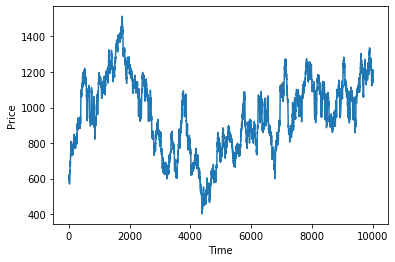

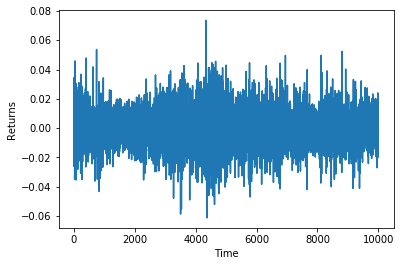

In [2]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)


# α*σ (risk aversion * variance)
# Note: Because Python 3 supports most unicode characters in variable names we
# could actually name this variable:
#
# ασ = 1
#
# Though it would probably be less convenient to type.  Similarly with ȳ = 1.
#
# For use in this simulation, these values are assumed constant 1, and won't
# generally change.  If there is a reason to change them we could make them
# additional paramters of the simulation, but for the purpose of demonstration
# we will make them global "constants", which in Python are typically written
# in ALL_CAPS to distinguish that they are "constant" (of course the Python
# language does not actually prohibit us from changing them).
A_SIG = 1.0
Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations
    from the constant fundamental given by pbar
    as x(t) = p(t)-pbar
    this is both a little simpler, and turns out to be a better
    thing to do numerically.  See notes for some details.

    T = Time Horizon
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret


p, lret, ret, ghret = gaunersdorfer_hommes()


# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(np.arange(len(p)), p)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# plot returns
fig_r, ax_r = plt.subplots()
ax_r.plot(np.arange(len(lret)), lret)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()

In the above version of the code, in addition to other minor tweaks, the *main* change is that the meat of the model code was moved into its own *function* named `gaunersdorfer_hommes()`.  Although one could take many different approaches to this, in this case I decided that it should take no *required* arguments.  All of the default parameters are given in global variables (`GH_DEFAULTS` and `GH_DEFAULTS_CHAOS`).  When we call the function we *may* override any of those defaults by passing them as keyword arguments (this is the `**kwargs`), like `gaunersdorfer_hommes(r=0.015)`.  But otherwise the defaults are used.

One driver of this particular design is that I noted that the original authors give two sets of parameters they'd like us to try, depending on whether or not we want to include additional random noise in the simulation.  Thus I put each set of default parameters in its own global variable, and we can select which set of defaults to start with by passing `chaos=False` (the default) or `chaos=True`).  This is just one possible approach that hews close to the original implementation, but makes it easier for us to try both versions of the simulation without modifying anything else (i.e. directly modifying the code to set the `chaos` option, as the original code asked us to do):

In [3]:
gaunersdorfer_hommes()

C:\Users\Erik M. Bray\Home\miniconda3\envs\agentfin\lib\site-packages\ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in true_divide


(array([[600.        ],
        [600.        ],
        [600.        ],
        ...,
        [685.11841354],
        [679.8357464 ],
        [673.5118107 ]]), array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.00047795],
        [-0.00774047],
        [-0.00934569]]), array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.00047806],
        [-0.00771059],
        [-0.00930215]]), array([[-1.6       ],
        [-1.6       ],
        [-1.6       ],
        ...,
        [-1.35741777],
        [-6.96778555],
        [-8.00377145]]))

In [8]:
# For some reason the display of the results is not being
# truncated by Numpy in this case, so well just manually
# truncated it for demonstration purposes...
gaunersdorfer_hommes(chaos=True)[0].flatten()[:10]

array([100.01      , 100.01      , 100.01      , 100.01      ,
       100.00643561,  99.99990682,  99.99218377,  99.98579318,
        99.98326199,  99.98621989])

Otherwise, the rest of the above example works exactly the same as the original: We now directly *call* the `gaunersdorfer_hommes()` function once, assigning its return values to variables, and then executing "module level" code to produce the plots.

What if we just want to write the code such that we can define and call `gaunersdorfer_hommes()` without necessarily creating any plots, or perhaps using the results to create different plots, or perform some other kind of statistical analysis?

The next step then would be to get rid of *all* code that runs directly in the module, and instead just define some functions for the plots as well (taking as input some arrays that *might* have been returned by `gaunersdorfer_hommes()` but could in principle be any arbitrary NumPy array):

In [6]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)


# α*σ (risk aversion * variance)
# Note: Because Python 3 supports most unicode characters in variable names we
# could actually name this variable:
#
# ασ = 1
#
# Though it would probably be less convenient to type.  Similarly with ȳ = 1.
#
# For use in this simulation, these values are assumed constant 1, and won't
# generally change.  If there is a reason to change them we could make them
# additional paramters of the simulation, but for the purpose of demonstration
# we will make them global "constants", which in Python are typically written
# in ALL_CAPS to distinguish that they are "constant" (of course the Python
# language does not actually prohibit us from changing them).
A_SIG = 1.0
Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations
    from the constant fundamental given by pbar
    as x(t) = p(t)-pbar
    this is both a little simpler, and turns out to be a better
    thing to do numerically.  See notes for some details.

    T = Time Horizon
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret


def plot_price(price):
    fig_p, ax_p = plt.subplots()
    ax_p.plot(np.arange(len(price)), price)
    plt.xlabel('Time')
    plt.ylabel('Price')
    return fig_p


def plot_returns(lret):
    fig_r, ax_r = plt.subplots()
    ax_r.plot(np.arange(len(lret)), lret)
    plt.xlabel('Time')
    plt.ylabel('Returns')
    return fig_r

Now when we execute the above example, there is no output.  That's because the plots are now wrapped in function definitions as well, and no functions are *called* in the above code.  Only *defined*.  This is our first real step towards modularity and reuse.  In fact as is this would be a perfectly good Python module to distribute and use by running (e.g. at a Python interactive prompt):


    >>> import gaunersdorfer_hommes
    >>> gaunersdorfer_hommes.gaunersdorfer_hommes()
    
or equivalently:

    >>> from gaunersdorfer_hommes import gaunersdorfer_hommes
    >>> import gaunersdorfer_hommes
 
(Perhaps we could also give it a snappier name in case we get tired of writing "gaunersdorfer_hommes" over and over, though this name has the advantage of being fairly unique (as opposed to something very generic and inspecific like "model"), and IPython/Jupyter and other IDEs provide auto-completion features, so maybe it's not too bad.)

In fact, let's go ahead and try it!  We can write the contents of a notebook cell directly to a file by placing `%%file <filename>` at the top of the cell and executing it (which saves the cell contents to the given filename rather than running the cell):

In [7]:
%%file gaunersdorfer_hommes.py
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)


# α*σ (risk aversion * variance)
# Note: Because Python 3 supports most unicode characters in variable names we
# could actually name this variable:
#
# ασ = 1
#
# Though it would probably be less convenient to type.  Similarly with ȳ = 1.
#
# For use in this simulation, these values are assumed constant 1, and won't
# generally change.  If there is a reason to change them we could make them
# additional paramters of the simulation, but for the purpose of demonstration
# we will make them global "constants", which in Python are typically written
# in ALL_CAPS to distinguish that they are "constant" (of course the Python
# language does not actually prohibit us from changing them).
A_SIG = 1.0
Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations
    from the constant fundamental given by pbar
    as x(t) = p(t)-pbar
    this is both a little simpler, and turns out to be a better
    thing to do numerically.  See notes for some details.

    T = Time Horizon
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret


def plot_price(price):
    fig_p, ax_p = plt.subplots()
    ax_p.plot(np.arange(len(price)), price)
    plt.xlabel('Time')
    plt.ylabel('Price')
    return fig_p


def plot_returns(lret):
    fig_r, ax_r = plt.subplots()
    ax_r.plot(np.arange(len(lret)), lret)
    plt.xlabel('Time')
    plt.ylabel('Returns')
    return fig_r

Overwriting gaunersdorfer_hommes.py


In [8]:
import gaunersdorfer_hommes

In [9]:
gaunersdorfer_hommes

<module 'gaunersdorfer_hommes' from 'C:\\Users\\Erik M. Bray\\Home\\src\\agentfin\\gaunersdorfer_hommes.py'>

In [10]:
price, lret, ret, ghret = gaunersdorfer_hommes.gaunersdorfer_hommes()

C:\Users\Erik M. Bray\Home\src\agentfin\gaunersdorfer_hommes.py:170: RuntimeWarning: invalid value encountered in true_divide
  n2tilde = np.exp(beta * u2[t-1]) / norm


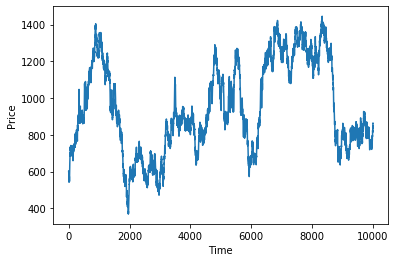

In [11]:
figure = gaunersdorfer_hommes.plot_price(price)

In [12]:
# Perhaps we want to save the plot to a file for later use:
# The plot_price() function as designed returns the figure object
# so that we can easily do this and other post-processing with
# the default plot, if so desired.
figure.savefig('gh_prices.png')

### An aside about modules and sys.path

If you have a Python script named `foobar.py`, and you run that script at the command-line like `python foobar.py`, one can see in a straightforward manner that the Python interpreter simply executes the lines of the script one by one until it reaches the end of the script, then exits (assuming no errors occur, or infinite loops).

There is, however, another way to execute a `.py` file, and that's by *importing* it as a *module* using the `import` statement, just as we did above with `import gaunersdorfer_hommes`.  In this case the module is executed line-by-line much in the same way, but how it is used is different.  Before the module is executed a special *namespace* is created for it in the form of a `module` object.  You won't normally create or interact with `module` objects often like you do with other types of Python objects, but it's worth mentioning that in some sense a module is just another object.  When you do `import foobar`, it's a little as if you ran (in some pseudocode) `foobar = load_module_in_namespace('foobar.py')`.  That is, `import foobar` actually creates a variable named `foobar` referencing the module.

The point of the module is that as `foobar.py` is executed, any functions or classes that are defined, and any global variables that are created, are assigned to the module namespace for us to access later, just as we did we were able to do above.  There's otherwise nothing that special about importing a Python file.  Any code that's in it (including code with side-effects, such as print statements) are run at import time.

So to create your own modules all you do is write your own `.py` file, define some objects in it, and then you can import it by running `import <module_name>`, where `<module_name>` is the same as the filename, but with the `.py` extension omitted. Let's try it with another example:

In [13]:
%%file foobar.py
"""A useless module."""

print("Importing foobar!")

foo = 1

def bar():
    return 2

Overwriting foobar.py


In [14]:
import foobar

Importing foobar!


In [15]:
foobar.foo

1

In [16]:
foobar.bar()

2

In [17]:
# The module object itself has some attributes of possible interest for inspection
print(foobar.__name__)
print(foobar.__file__)
print(foobar.__doc__)
# Among others...

foobar
C:\Users\Erik M. Bray\Home\src\agentfin\foobar.py
A useless module.


If some module isn't working the way you expected it to (e.g. a function is missing that you're sure you defined) try printing `module_name.__file__` as we did just above to make sure `import module_name` is actually importing the file you think it's importing.

This raises an interesting question:  We know that when we run `import foobar`, Python is searching for a file named `foobar.py`.  But where is it searching for it?  What if I have more than one file named `foobar.py` somewhere?  Does it look over my entire computer for it?  Certainly not--that would take forever, and could be dangerous.

Rather, for this purpose, Python uses a special internal variable called `sys.path`.  In my case it looks like this (on your computer, depending on the OS and the Python distribution it may look different):

In [18]:
import sys
sys.path

['C:\\Users\\Erik M. Bray\\Home\\miniconda3\\envs\\agentfin\\python36.zip',
 'C:\\Users\\Erik M. Bray\\Home\\miniconda3\\envs\\agentfin\\DLLs',
 'C:\\Users\\Erik M. Bray\\Home\\miniconda3\\envs\\agentfin\\lib',
 'C:\\Users\\Erik M. Bray\\Home\\miniconda3\\envs\\agentfin',
 '',
 'C:\\Users\\Erik M. Bray\\Home\\miniconda3\\envs\\agentfin\\lib\\site-packages',
 'c:\\users\\erik m. bray\\home\\src\\agentfin\\gaunersdorfer_hommes',
 'C:\\Users\\Erik M. Bray\\Home\\miniconda3\\envs\\agentfin\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Erik M. Bray\\.ipython']

What we get is a list of directory names.  These are the directories that Python searches in for modules (in my case there is also a `python36.zip` file--Python can also search for modules inside zip files, though this is rarely used execept for special purposes).

So upon `import foobar` Python goes through each of those directories in order until it finds a `foobar.py` in of them, and then stops at the first one (there are some other things that can also be recognized as the `foobar` module, such as a package, which we'll look at in a bit).

Not having a solid grasp on `sys.path` and how it works can lead to a few common beginner mistakes involving getting confused about what paths their files on.  In particular, one of the default `sys.path` entries is almost always the empty string `''`.  In the case of `sys.path` this actually represents the *current working directory*.  This is why we were able, from this notebook, to write out `foobar.py` and then immediately import it.  We wrote it directly to our current directory so we can import it as `foobar`:

In [19]:
import os; os.listdir('.')

['.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'chiarella',
 'foobar.py',
 'gaunersdorfer_hommes',
 'gaunersdorfer_hommes.ipynb',
 'gaunersdorfer_hommes.py',
 'gh_prices.png',
 '__pycache__']

If we changed directories we wouldn't be able to import it anymore.  We'll demonstrate this in a new Python interpreter:

In [20]:
import sys
import subprocess as sp
# This should work: sys.executable points to the same python executable
# we are using currently, so this just runs a new copy of it and executes
# the code "import foobar; print(foobar.foo)"
# This is equivalent to running at the command line:
#
#     $ python -c 'import foobar; print(foobar.foo)' 2>&1
#
print(sp.run([sys.executable, '-c', 'import foobar; print(foobar.foo)'],
              encoding='utf8', stdout=sp.PIPE, stderr=sp.STDOUT).stdout)

Importing foobar!
1



In [21]:
# This does the same thing again, but we pass cwd='..' to subprocess.check_output
# to change out of the current directory before running the new Python
print(sp.run([sys.executable, '-c', 'import foobar; print(foobar.foo)'],
              cwd='..', encoding='utf8', stdout=sp.PIPE, stderr=sp.STDOUT).stdout)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'foobar'



An especially painful beginner trap is when you have `.py` file in your current
directory that has a generic name that happens to coincide with another common
module that other code you use depends on.  I've seen this for example when someone
writes a bunch of routines that write to files, and names it `io.py`.  This will
completely break any other code that relies on the standard `io` module.  Fortunately
some Python environments and distributions will arrange things so that standard
library modules are never overshadowed, but this is not always a guarantee.

As one more little exercise, let's try *modifying* our `foobar.py` file and then re-importing it:

In [22]:
%%file foobar.py
print("This really ought to be printed when we import foobar!")

foo = 42

def bar():
    return 3

Overwriting foobar.py


In [23]:
import foobar

Alas, nothing is printed like it was last time.  Also, didn't we change the value of `foo` to `42`?

In [24]:
foobar.foo

1

It seems that we are using an older version of the `foobar` module, even though we just edited it.  In fact,
this demonstrates another gotcha that's worth being aware of when writing and working with modules: When you
import a module Python *caches* the result, so that within the same interpreter session future attempts to
`import foobar` are no-ops.  If we ran a different Python (e.g. at the command-line, or by restarting the
Jupyter kernel), it would work:

In [25]:
! python -c "import foobar"

This really ought to be printed when we import foobar!


There is an easy way to work around this though, at least for simple modules that don't have any dependencies.  The place where the modules are cached is another special built-in variable called [sys.modules](https://docs.python.org/3/library/sys.html#sys.modules) which is a dictionary that we are free to poke around in and modify:

In [26]:
import sys
sys.modules['foobar']

<module 'foobar' from 'C:\\Users\\Erik M. Bray\\Home\\src\\agentfin\\foobar.py'>

An easy, portable way to force reloading the `foobar` module is to simply delete its cached entry from `sys.modules`:

In [27]:
del sys.modules['foobar']

In [28]:
import foobar

This really ought to be printed when we import foobar!


In [29]:
foobar.foo

42

However, use this trick with *extreme caution!*  If you already imported some modules which are *dependent* on your module, and you reload your module in this way, the dependent modules will still be using the *old version* of the module, and will have to be reloaded as well, and so on recursively through the dependency tree.  There is no good way built into Python to do this thoroughly and it turns out to be a hard problem in general.  So the safest thing to do when modifying a module (if anything else depends on it) is just restart Python, unfortunately.

Note: Something I often see researchers struggling with is managing `sys.path` and their Python modules in such a way that they are able to import them.  I often see code that manually adds hard-coded entries to `sys.path`, such as adding the path on their computer to all their Python modules so they can be found when they import each other.  Or similarly manipulating `PYTHONPATH`, a special environment variable that adds new entries to `sys.path`.

When following best practices this kind of path manipulation and worrying about where files are should *almost never* be necessary (at least for the case of running `import`; if you have scripts you need to at least know where to script is, though even that can be avoided).

Unfortunately, the best solution to this problem requires learning a number of concepts, including how to make Python package distributions, and how to use programs like `pip`.  It is also very helpful to have concepts like "virtual environments" (or equivalently conda environments if you are using [conda](https://docs.conda.io/en/latest/).  It can be a lot.  We'll go over some of these techniques toward the end.

### Getting back to the refactoring: creating a package